# **필요한 모델 로드**

In [66]:
import torch
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2Model, BertTokenizer, BertModel
import re
import torch.nn as nn
import pandas as pd
from google.colab import drive
import pickle
import random

In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# 질문 타입 분류기 모델 정의
class QuestionClassification(nn.Module):
    def __init__(self, gpt2_model_name='skt/kogpt2-base-v2', num_labels=4):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained(gpt2_model_name)
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_labels)
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained(
            gpt2_model_name,
            bos_token="</s>",
            eos_token="</s>",
            unk_token="<unk>",
            pad_token="<pad>",
            mask_token="<unused0>"
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

    def clean_text(self, text):
        return re.sub(r"([?.!,])", r" ", text)

    def predict(self, question):
        question = self.clean_text(question)
        tokens = self.tokenizer.tokenize(question)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        max_len = 40
        padded_ids = token_ids[:max_len] + [self.tokenizer.pad_token_id] * max(0, max_len - len(token_ids))
        mask = [1 if i < len(padded_ids) else 0 for i in range(max_len)]

        token_ids = torch.LongTensor(padded_ids).unsqueeze(0).to(self.device)
        mask = torch.LongTensor(mask).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits = self(input_ids=token_ids, attention_mask=mask)
            predicted_label = torch.argmax(logits, dim=1).item()
        return predicted_label

In [69]:
# 요리명 기반 응답 모델
import torch
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

class BasedNameModel():
    def __init__(self):
        # 특수 토큰 정의
        self.Q_TKN = "<usr>"
        self.A_TKN = "<sys>"
        self.BOS = '</s>'
        self.EOS = '</s>'
        self.MASK = '<unused0>'
        self.SENT = '<unused1>'
        self.PAD = '<pad>'

        self.tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2',
                                                                 bos_token=self.BOS,
                                                                 eos_token=self.EOS,
                                                                 unk_token="<unk>",
                                                                 pad_token=self.PAD,
                                                                 mask_token=self.MASK)
        self.model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_dict = torch.load('/content/drive/MyDrive/Final_project/based_name/kogpt2_model_3.pt', map_location=self.device)

        self.model.load_state_dict(state_dict)
        self.model.to(self.device)

    def predict(self, user_text):
        self.model.eval()
        with torch.no_grad():
          a = ''
          while True:
            input_ids = torch.LongTensor(self.tokenizer.encode(self.Q_TKN + user_text + self.SENT + self.A_TKN + a,
                                                               add_special_tokens=True)).unsqueeze(dim=0)
            input_ids = input_ids.to(self.device)
            outputs = self.model(input_ids)

            logits = outputs.logits

            pred = torch.argmax(logits, dim=-1)
            gen_token = self.tokenizer.convert_ids_to_tokens(pred[0].cpu().numpy().tolist())[-1]
            if gen_token == self.EOS:
              break
            a += gen_token.replace("▁", " ")

        return a.strip()

In [70]:
# 재료 기반 질문 응답 모델
class BasedIngredientModel():
    def __init__(self):
        # 특수 토큰 정의
        self.Q_TKN = "<usr>"
        self.A_TKN = "<sys>"
        self.BOS = '</s>'
        self.EOS = '</s>'
        self.MASK = '<unused0>'
        self.SENT = '<unused1>'
        self.PAD = '<pad>'

        self.tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2',
                                                                 bos_token=self.BOS,
                                                                 eos_token=self.EOS,
                                                                 unk_token="<unk>",
                                                                 pad_token=self.PAD,
                                                                 mask_token=self.MASK)
        self.model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_dict = torch.load('/content/drive/MyDrive/Final_project/based_ingredient/Ingredient_base_QA_model.pt', map_location=self.device)
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)

    def predict(self, user_text):
        self.model.eval()
        with torch.no_grad():
          a = ''
          while True:
            input_ids = torch.LongTensor(self.tokenizer.encode(self.Q_TKN + user_text + self.SENT + self.A_TKN + a,
                                                               add_special_tokens=True)).unsqueeze(dim=0)
            input_ids = input_ids.to(self.device)
            outputs = self.model(input_ids)

            logits = outputs.logits

            pred = torch.argmax(logits, dim=-1)
            gen_token = self.tokenizer.convert_ids_to_tokens(pred[0].cpu().numpy().tolist())[-1]
            if gen_token == self.EOS:
              break
            a += gen_token.replace("▁", " ")

        return a.strip()

In [71]:
# 요리 추천 질문 응답 모델
class FoodSuggestion():
    def __init__(self):
        # 특수 토큰 정의
        self.Q_TKN = "<usr>"
        self.A_TKN = "<sys>"
        self.BOS = '</s>'
        self.EOS = '</s>'
        self.MASK = '<unused0>'
        self.SENT = '<unused1>'
        self.PAD = '<pad>'

        self.tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2',
                                                                 bos_token=self.BOS,
                                                                 eos_token=self.EOS,
                                                                 unk_token="<unk>",
                                                                 pad_token=self.PAD,
                                                                 mask_token=self.MASK)
        self.model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_dict = torch.load('/content/drive/MyDrive/Final_project/food_suggestion/kogpt2_chatbot_model.pt', map_location=self.device)

        self.model.load_state_dict(state_dict)
        self.model.to(self.device)

    def predict(self, user_text):
        self.model.eval()
        with torch.no_grad():
          a = ''
          while True:
            input_ids = torch.LongTensor(self.tokenizer.encode(self.Q_TKN + user_text + self.SENT + self.A_TKN + a,
                                                               add_special_tokens=True)).unsqueeze(dim=0)
            input_ids = input_ids.to(self.device)
            outputs = self.model(input_ids)

            logits = outputs.logits

            pred = torch.argmax(logits, dim=-1)
            gen_token = self.tokenizer.convert_ids_to_tokens(pred[0].cpu().numpy().tolist())[-1]
            if gen_token == self.EOS:
              break
            a += gen_token.replace("▁", " ")

        return a.strip()


In [72]:
# 모델 매니저
class ModelManager:
    def __init__(self):
        self.models = {}

    def load_model(self, model_name, model_class, *args, **kwargs):
        """
        만든 모델들을 초기화하고 딕셔너리에 담기.
        args, kwargs 는 모델에 따라 필요하면 넣는 인자값들.
        현재 우리 프로젝트에서는 아직은 사용하는 모델들은 없음.
        """
        model = model_class(*args, **kwargs)
        if model_class == QuestionClassification:
            model.load_state_dict(torch.load('/content/drive/MyDrive/Final_project/q_classifier/question_classification_model_14.pth', map_location=model.device))
            model.eval()

        self.models[model_name] = model

    def get_model(self, model_name):
        """
        지정된 이름의 모델을 반환하는 메서드.
        model_name: 반환할 모델의 이름
        """
        return self.models.get(model_name)

    def predict(self, model_name, user_text ):
      """
      딕셔너리에 저장된 각 모델들 중에서 model_name에 해당되는 모델의 predic()메서드를 호출하는 메서드
      """

      return self.models[model_name].predict(user_text)

In [73]:
# 모델 매니저로 모델 로드
model_manager = ModelManager()
model_manager.load_model('classifier', QuestionClassification)
model_manager.load_model("basedName", BasedNameModel)
model_manager.load_model("basedIngredient", BasedIngredientModel)
# model_manager.load_model("classifyIngredients", ClassifierIngredients)
model_manager.load_model("foodSuggestion", FoodSuggestion)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called f

# **모델 테스트**



### **1. all_recipes2 데이터셋을 이용하여 0, 1, 3으로 라벨링 된 질문을 각각 50개씩 생성**

**- 개수 늘리고 싶으면 def generate_questions_with_labels 함수의 num_questions=50 값 수정**

In [74]:
# 0, 1, 3으로 라벨링 된 질문을 각각 50개씩 생성

class QuestionGenerator:

    # 질문 타입과 유형 정의
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.templates_dict = {
            'Name': [
                "Name은 어떻게 만들어?",
                "Name 레시피 알려줘",
                "Name 요리방법이 궁금해",
                "Name"
            ],
            'Ingredients': [
                "Ingredients로 만들 수 있는 요리 뭐가 있어?",
                "Ingredients를 이용해 만드는 요리 알려줘",
                "Ingredients로 뭘 만들 수 있을까?",
                "Ingredients"
            ],
            'Type': [
                "Type 요리 추천해줘",
                "Type 중에서 뭐가 맛있어?",
                "Type 중에 어떤 요리가 괜찮아?"
                "Type"
            ]
        }

    # 정규화 함수
    @staticmethod
    def remove_special_characters(text):
        fractions = [u'\u00BC', u'\u00BD', u'\u00BE', u'\u2150', u'\u2151', u'\u2152', u'\u2153', u'\u2154', u'\u2155', u'\u2156', u'\u2157', u'\u2158', u'\u2159', u'\u215A', u'\u215B', u'\u215C', u'\u215D', u'\u215E']
        for fraction in fractions:
            text = re.sub(fr'{fraction}[\w\s]*', ' ', text)
        text = re.sub(r'\(.*?\)|[^\w\s]|\d+[\w\s]*|[A-Za-z]+[\w\s]*', ' ', text)
        text = re.sub(r'작은술|작은 술|큰 술|큰술|컵|반줌|반 줌|티|스푼|국자|공기|사방|약간|씩|한 꼬집|한꼬집|두 꼬집|두꼬집|세꼬집|세 꼬집|조금|생략|가능|적당|적당량|한 줌|한줌|두 줌|두줌|세 줌|세줌|취향것|톡톡|큰 것|큰것|소량|국자|되|또는', ' ', text)
        return re.sub(r'\s+', ' ', text).strip()

    # 조사 적용 함수
    def determine_josa(self, word, next_char):
        if not word:
            return ''
        last_char = word[-1]
        has_batchim = (ord(last_char) - 44032) % 28 > 0
        if next_char == '으로' or next_char == '로':
            return '로' if last_char == 'ㄹ' or not has_batchim else '으로'
        elif next_char in ['을', '를']:
            return '을' if has_batchim else '를'
        elif next_char in ['이', '가']:
            return '이' if has_batchim else '가'
        elif next_char in ['은', '는']:
            return '은' if has_batchim else '는'
        elif next_char == '에':
            return '에'
        else:
            return ''

    def replace_with_josa(self, text, word):
        updated_text = text.replace('Name', word)  # Replace placeholder 'Name' with actual word
        pattern = rf'{word}(으?로|에|은|는|이|가|을|를)'
        return re.sub(pattern, lambda m: word + self.determine_josa(word, m.group(1)), updated_text)

    # 질문 생성 및 라벨링
    def generate_questions_with_labels(self, num_questions=100):
        name_list = self.dataframe['Name'].unique().tolist()

        # Ingredients 열 처리
        ingredients_list = sum(self.dataframe['Ingredients'].apply(lambda x: self.remove_special_characters(x).split()).tolist(), [])
        ingredients_list = list(set(ingredients_list))

        type_list = self.dataframe['Type'].unique().tolist()

        questions = []
        labels = []

        for data_list, placeholder in zip([name_list, ingredients_list, type_list], ['Name', 'Ingredients', 'Type']):
            label = {'Name': 0, 'Ingredients': 1, 'Type': 3}[placeholder]
            for _ in range(num_questions):
                if placeholder == 'Ingredients':
                    # 재료 1개 이상 무작위 선택, 쉼표로 구분
                    random_ingredients = ', '.join(random.sample(ingredients_list, random.randint(1, 3)))
                    question = self.replace_with_josa(random.choice(self.templates_dict[placeholder]).replace(placeholder, random_ingredients), random_ingredients)
                else:
                    random_word = random.choice(data_list)
                    question = self.replace_with_josa(random.choice(self.templates_dict[placeholder]).replace(placeholder, random_word), random_word)

                questions.append(question)
                labels.append(label)
        return pd.DataFrame({'Question': questions, 'Label': labels})

In [75]:
# all_recipes2 데이터셋에 QuestionGenrator 적용

file_path = ('/content/drive/MyDrive/Final_project/all_recipes2.csv')
recipes_df = pd.read_csv(file_path)

question_generator = QuestionGenerator(recipes_df)
eval_df = question_generator.generate_questions_with_labels()

In [76]:
# 질문셋 저장
# save_path = ('/content/drive/MyDrive/Final_project/evaluation/eval_question_df.csv')
# eval_df.to_csv(save_path, encoding='utf-8-sig')

### **2. 생성된 질문 분류기를 통해 예측분류 및 시각화**

In [77]:
# 150개의 질문을 질문분류기를 통해 예측

# # 질문셋 로드
# eval_df = pd.read_csv('/content/drive/MyDrive/Final_project/evaluation/eval_question_df.csv')

# 모델의 예측 결과와 실제 라벨을 저장할 리스트 초기화
results = []

# 각 질문에 대해 모델의 예측 수행 및 결과 저장
for question, actual_label in zip(eval_df['Question'], eval_df['Label']):
    predicted_label = model_manager.predict("classifier", question)
    results.append({
        'Question': question,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label
    })

results_df = pd.DataFrame(results)

# 정확도 계산
accuracy = sum(r['Actual Label'] == r['Predicted Label'] for r in results) / len(results)

# 결과 출력
print(f"정확도: {accuracy:.2f}")
print(results_df.head())

정확도: 0.76
             Question  Actual Label  Predicted Label
0             딸기찹쌀볼맛탕             0                0
1  파프리카컵리조토 요리방법이 궁금해             0                1
2     멸치무조림은 어떻게 만들어?             0                1
3       멸치무조림 레시피 알려줘             0                1
4              낙지꼬치구이             0                0


<Figure size 1000x600 with 0 Axes>

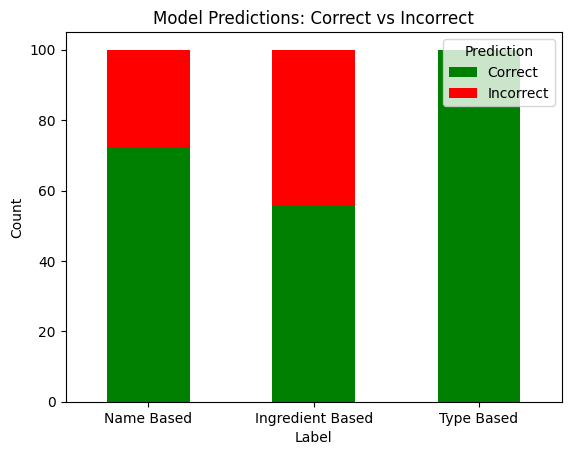

In [78]:
# 예측 결과 시각화

import matplotlib.pyplot as plt
import seaborn as sns

# 예측된 라벨과 실제 라벨에 따라 데이터를 분류
correct_predictions = results_df[results_df['Actual Label'] == results_df['Predicted Label']]
incorrect_predictions = results_df[results_df['Actual Label'] != results_df['Predicted Label']]

# 카테고리별 정확한 예측과 부정확한 예측의 수를 계산
correct_counts = correct_predictions['Actual Label'].value_counts()
incorrect_counts = incorrect_predictions['Actual Label'].value_counts()

# 시각화를 위한 데이터프레임 생성
vis_df = pd.DataFrame({'Correct': correct_counts, 'Incorrect': incorrect_counts}).fillna(0)

# 시각화
plt.figure(figsize=(10, 6))
vis_df.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Model Predictions: Correct vs Incorrect')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Name Based', 'Ingredient Based', 'Type Based'], rotation=0)
plt.legend(title='Prediction')
plt.show()

### **3. 정확하게 분류된 질문들만 각 모델로 답변 생성**

In [83]:
# 정확하게 분류된 질문
correctly_classified_df = results_df[results_df['Actual Label'] == results_df['Predicted Label']]

correctly_classified_df.head()

print("정확하게 분류된 질문 개수: ", len(correctly_classified_df))

정확하게 분류된 질문 개수:  228


In [84]:
# 부정확하게 분류된 질문
uncorrectly_classified_df = results_df[results_df['Actual Label'] != results_df['Predicted Label']]
print("부정확하게 분류된 질문 개수 : ", len(uncorrectly_classified_df))
uncorrectly_classified_df

부정확하게 분류된 질문 개수 :  72


,Question,Actual Label,Predicted Label
1,파프리카컵리조토 요리방법이 궁금해,0,1
2,멸치무조림은 어떻게 만들어?,0,1
3,멸치무조림 레시피 알려줘,0,1
5,꽈리고추밀가루찜은 어떻게 만들어?,0,2
6,강된장찌개 레시피 알려줘,0,1
...,...,...,...
184,"샤미, 겨자장을 이용해 만드는 요리 알려줘",1,0
185,"모, 꼬치, 식초로 만들 수 있는 요리 뭐가 있어?",1,0
188,"닭발, 생삼겹살으로 만들 수 있는 요리 뭐가 있어?",1,0
190,새우살으로 만들 수 있는 요리 뭐가 있어?,1,0


In [81]:
# 결과를 저장할 리스트 초기화
model_responses = []

# 정확하게 분류된 질문들에 대해 모델 적용
for index, row in correctly_classified_df.iterrows():
    question = row['Question']
    label = row['Predicted Label']

    if label == 0:
        # 요리명 기반 응답 모델 적용
        response = model_manager.predict("basedName", question)
    elif label == 1:
        # 재료 기반 응답 모델 적용
        response = model_manager.predict("basedIngredient", question)
    elif label == 3:
        # 요리 추천 질문 응답 모델 적용
        response = model_manager.predict("foodSuggestion", question)
    else:
        response = "해당 질문에 대한 모델이 없습니다."

    model_responses.append({
        'Question': question,
        'Label': label,
        'Model Response': response
    })

# 결과 데이터프레임 생성
responses_df = pd.DataFrame(model_responses)

# 결과 확인
responses_df.head()

KeyboardInterrupt: 

In [ ]:
responses_df.to_csv('/content/drive/MyDrive/Final_project/evaluation/model_responses_correctly_classified_Question.csv', encoding='utf-8-sig')